# 1. Imports

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 2. Read data

In [31]:
df_expGroups = pd.read_csv("data/experimentalGroups.csv")

df_expGroups.head()

,assignment_id,user_id,question_num,toolName,numEvaluation,timeTaken,score
0,321233,96550495,1,No feedback requested,12,15.014867,30
1,320994,55948835,1,AI-Socrates,8,23.837567,30
2,320992,1464159,1,No feedback requested,4,52.849017,30
3,321323,11825285,1,No feedback requested,17,57.447117,30
4,321094,25317458,1,No feedback requested,4,41.686267,30


In [32]:
df_requests = pd.read_csv("data/requests.csv")
df_requests.head()

,code_id,assignment_id,user_id,question_num,toolName,query,TA Service Time,content,testcases
0,10043442,320994,55948835,1,AI-Socrates,,0.238817,#include <stdio.h>\r\n#include <stdlib.h>\r\n\...,"[{'index': '77062', 'input': '2\n4 0\n4 2', 'o..."
1,10044232,321318,87567466,1,AI-Default,i am not getting what is error in this code ?,0.092000,#include <stdio.h>\r\n#include <stdlib.h>\r\n\...,"[{'index': '77062', 'input': '2\n4 0\n4 2', 'o..."
2,10045358,321252,95178244,1,AI-Socrates,,0.101500,#include <stdio.h>\r\n#include <stdlib.h>\r\n\...,"[{'index': '77062', 'input': '2\n4 0\n4 2', 'o..."
3,10045425,321245,76587747,1,AI-Socrates,this code for now is only trying to print the...,0.116850,#include <stdio.h>\r\n#include <stdlib.h>\r\n\...,"[{'index': '77062', 'input': '2\n4 0\n4 2', 'o..."
4,10046660,320987,691325,1,AI-Default,,0.170133,#include <stdio.h>\r\n#include <stdlib.h>\r\n\...,"[{'index': '77062', 'input': '2\n4 0\n4 2', 'o..."


In [33]:
df_feedback = pd.read_csv("data/feedbacks.csv")
df_feedback.head()

,code_id,question_num,toolName,feedbackIndex,lineNum,feedback
0,10088303,2,TA (AI-Default),1,24,Consider the correct size for allocating memor...
1,10088303,2,TA (AI-Default),2,29,Modify the input handling to correctly differe...
2,10088303,2,TA (AI-Default),3,54,Ensure you are allocating the correct amount o...
3,10088303,2,TA (AI-Default),4,66,Memory allocation here is unnecessary and may ...
4,10088303,2,TA (AI-Default),5,77,The condition to check if the stack is empty s...


In [34]:
df_ratings = pd.read_csv("data/feedbackRatings.csv")
df_ratings.head()

,code_id,question_num,toolName,key,feedbackIndex,value
0,10090983,1,AI-Default,speed,NaN,1
1,10090983,1,AI-Default,line,1.0,1
2,10090983,1,AI-Default,line,2.0,1
3,10090983,1,AI-Default,accurate,NaN,1
4,10090983,1,AI-Default,line,4.0,1


# 3. Tables

# 3.1 Table-1: Distribution of experimental groups

In [35]:
full_mark = 30

# Group by `question_num` and `toolName`
aggregation_result = df_expGroups.groupby(['question_num', 'toolName']).agg(
    number_of_students=('user_id', 'nunique'),  # Count distinct students
    full_marks_students=('user_id', lambda x: x[df_expGroups.loc[x.index, 'score'] == full_mark].nunique()) # Count distinct students with full marks
).reset_index()

aggregation_result['%Completion'] = round(100 * aggregation_result['full_marks_students'] / aggregation_result['number_of_students'], 1)
aggregation_result['number_of_requests'] = [len(df_requests[df_requests['toolName'] == row['toolName']]) for i, row in aggregation_result.iterrows()]

aggregation_result

,question_num,toolName,number_of_students,full_marks_students,%Completion,number_of_requests
0,1,AI-Default,23,19,82.6,44
1,1,AI-Socrates,23,18,78.3,49
2,1,No feedback requested,126,96,76.2,0
3,2,No feedback requested,130,73,56.2,0
4,2,TA (AI-Default),5,2,40.0,7
5,2,TA (AI-Socrates),11,4,36.4,15
6,2,TA (Manual),13,5,38.5,17


In [36]:
for toolName in df_feedback['toolName'].unique():
    df_tool = df_feedback[df_feedback['toolName'] == toolName]
    row = df_tool.iloc[0]
    lineNum = row['lineNum']
    feedback = row['feedback']
    print(f'{toolName}: (Line-{lineNum}) {feedback}')    

TA (AI-Default): (Line-24) Consider the correct size for allocating memory to a node.
AI-Default: (Line-21) Consider updating the direction based on the previous move's direction, not just the initial direction.
TA (Manual): (Line-65) think about it..is this really correct?...you are moving top ahead while it should point to prev element (which is new top element after this pop)
TA (AI-Socrates): (Line-45) Consider how scanf is used with strings. Do you need to use the '&' operator when reading a string into a character array?
AI-Socrates: (Line-16) Consider how much memory you need to allocate for 'ans'. How does the size of 'struct posDir' compare to the size of 'struct posDir*'?


# 4. Figures

In [37]:
color_map = {
    'None': '#A9A9A9',
    'AI(Default)': '#4DBEEE',
    'AI(Socratic)': '#0072BD',
    'TA-AI(Default)': '#82E0AA',
    'TA-AI(Socratic)': '#196F3D',
    'TA-Manual': '#F4D03F',
}

legend_mapping = {'No feedback requested': 'None', 'AI-Socrates': 'AI(Socratic)', 'AI-Default': 'AI(Default)', 
                      'TA (Manual)': 'TA-Manual', 'TA (AI-Socrates)': 'TA-AI(Socratic)', 'TA (AI-Default)': 'TA-AI(Default)'}

In [38]:

def boxplot(df, x, ylabel, xlim, fig=None, axes=None, isSetTitle=True, isSetYlabel=True, isSetYTick=True):
    # Rename toolName for better readability
    df['Group'] = df['toolName'].replace(legend_mapping)

    # Define color palette (you can use any color palette you prefer)
    palette = color_map

    # Create subplots
    index = 1
    if fig is None or axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(3.25 * 2, 2.5))  # Adjust figsize as needed
        index = 0

    question_num = (index + 1)

    # Plot boxplots for each question number
    ax = axes[index]
    sns.boxplot(y="Group", legend=False, x=x, data=df, palette=palette, ax=ax, medianprops=None) #dict(color="black", alpha=0.7),)

    if isSetTitle:
        ax.set_title(f'Question Q{question_num}')        
    if index == 0 and isSetYlabel:
        ax.set_ylabel('Group')    
    else:
        ax.set_ylabel('')  # Clear ylabel for the second subplot

    if not isSetYTick:
        ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
    ax.set_xlabel(ylabel)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')  # Rotate x-axis labels for better readability

    # ax.set_xticks(ax.get_xticks().tolist() + [0, xlim])
    # ax.set_xticks(sorted(set(ax.get_xticks())))
    ax.set_xlim(left=0)  # Remove negative x-ticks
    plt.xlim(0, xlim)

    # Set font sizes
    plt.rc('axes', titlesize=12)     # Title font size
    plt.rc('axes', labelsize=10)     # Axis labels font size
    plt.rc('xtick', labelsize=10)     # X-tick labels font size
    plt.rc('ytick', labelsize=10)     # Y-tick labels font size
    plt.rc('legend', fontsize=10)     # Legend font size

    # Adjust layout
    fig.tight_layout()

    return fig, axes

In [39]:
def colplots(df, order=[]):
    # Get unique question numbers
    question_nums = df['question_num'].unique()

    # Rename toolName for better readability
    df['Group'] = df['toolName'].replace(legend_mapping)

    # Define color palette (you can use any color palette you prefer)
    palette = color_map

    # Create subplots
    num_questions = len(question_nums)
    fig, axes = plt.subplots(1, num_questions, figsize=(3.25 * num_questions, 2.5), sharey=True)  # Adjust figsize as needed
    if type(axes) != np.ndarray:
        axes = [axes]

    df['key'] = df['key'].str.replace(' ', '').str.capitalize()  # Convert key to camel case

    # Plot column plots for each question number
    for ax, question_num in zip(axes, question_nums):
        df = df[df['key'] != 'Line']  # Filter out 'line' ratings
        df = df.sort_values(by=['key', 'Group'], ascending=[True, True]) # Sort by 'key' column followed by 'Group' column
        
        sns.barplot(x="key", y="Percentage", hue="Group", data=df[df['question_num'] == question_num], palette=palette, ax=ax, order=order)
        
        ax.set_title(f'Question Q{question_num}')

        if ax == axes[0]:
            ax.set_ylabel('Percentage (%)')
        else:
            ax.set_ylabel('')

        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', wrap=True)  # Rotate and wrap x-tick labels
        ax.get_legend().remove() 

    # Create a custom legend
    handles, labels = axes[0].get_legend_handles_labels()
    for ax in axes[1:]:
        h, l = ax.get_legend_handles_labels()
        handles += h
        labels += l

    # Remove duplicates from handles and labels
    by_label = dict(zip(labels, handles))
    new_labels = [legend_mapping[label] if label in legend_mapping else label for label in by_label.keys()]
    new_handles = by_label.values()

    # Add custom legend to the plot on the top center
    fig.legend(new_handles, new_labels, bbox_to_anchor=(0.42, 1.2), loc='upper center', frameon=False, ncol=3)
    # Set font sizes
    plt.rc('axes', titlesize=12)     # Title font size
    plt.rc('axes', labelsize=12)     # Axis labels font size
    plt.rc('xtick', labelsize=10)     # X-tick labels font size
    plt.rc('ytick', labelsize=10)     # Y-tick labels font size
    plt.rc('legend', fontsize=10)     # Legend font size

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for the legend

    return fig, axes

## 4.1 Figure 3a: Students receive AI hints for Q1

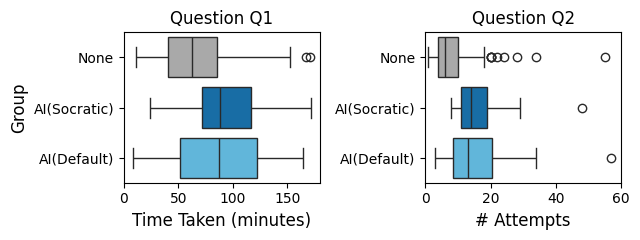

In [40]:
df_q1 = df_expGroups[df_expGroups['question_num'] == 1]

fig, axes = boxplot(df_q1, "timeTaken", "Time Taken (minutes)", 180)
fig, axes = boxplot(df_q1, "numEvaluation", "# Attempts", 60, fig=fig, axes=axes)

## 4.2 Figure 3b: Students receive hints through TAs for Q2

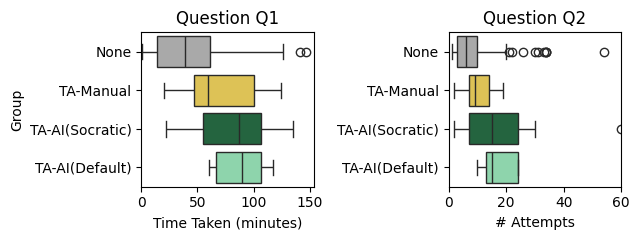

In [41]:
df_q2 = df_expGroups[df_expGroups['question_num'] == 2]

fig, axes = boxplot(df_q2, "timeTaken", "Time Taken (minutes)", 180)
fig, axes = boxplot(df_q2, "numEvaluation", "# Attempts", 60, fig=fig, axes=axes)

## 4.3 Figure 4: Feedback service time

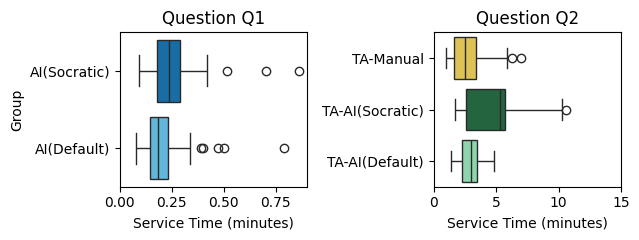

In [42]:
df_q1 = df_requests[df_requests['question_num'] == 1]
df_q2 = df_requests[df_requests['question_num'] == 2]

fig, axes = boxplot(df_q1, "TA Service Time", "Service Time (minutes)", 15)
fig, axes = boxplot(df_q2, "TA Service Time", "Service Time (minutes)", 15, fig=fig, axes=axes)

## 4.4 Figure 5: Feedback ratings by students

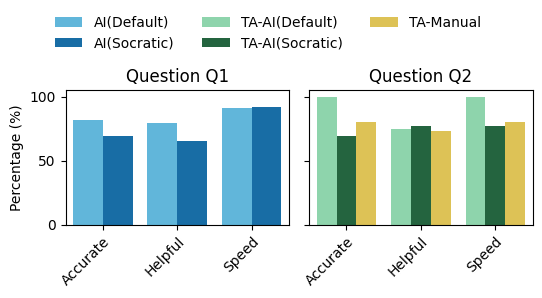

In [43]:
grouped_df = df_ratings.groupby(['question_num', 'toolName', 'key'])['value'].apply(lambda x: (x.sum() / len(x)) * 100).reset_index()
grouped_df.rename(columns={'value': 'Percentage'}, inplace=True)
grouped_df['Percentage'] = grouped_df['Percentage'].round(2)

fig, axes = colplots(grouped_df, order=['Accurate', 'Helpful', 'Speed']) 

# 5. Statistical Significance

In [44]:

def statisticalAnalysis(df, key):
    # ANOVA test 
    data = pd.DataFrame({
        'group': df['toolName'],
        'value': df[key]
    })
    # Remove null values
    data = data.dropna()

    # Model the data
    model = ols('value ~ group', data=data).fit()
    if len(data) == 0:
        st.warning("No data available for analysis.")
        return

    # Create eh anova table
    anova_table = sm.stats.anova_lm(model, typ=2)
    if anova_table.empty:
        st.warning("ANOVA table is empty. No data to analyze.")
        return

    # Eta squared
    anova_table['eta_sq'] = anova_table['sum_sq'] / anova_table['sum_sq'].sum()

    # Result interpretation
    F_statistic = anova_table['F'][0]
    p_value = anova_table['PR(>F)'][0]
    eta_squared = anova_table['eta_sq'][0]

    # Perform Tukey's HSD test 
    tukey_time = pairwise_tukeyhsd(endog=data['value'], groups=data['group'])

    print(f'F-statistic: {F_statistic}, p-value: {p_value}, eta squared: {eta_squared}')
    print(tukey_time)

## 5.1 Statistical Significance: AI styles

In [45]:
df_q1 = df_expGroups[df_expGroups['question_num'] == 1]

print('Time Taken:')
statisticalAnalysis(df_q1, 'timeTaken')

print('\n\nNumber of Attempts:')
statisticalAnalysis(df_q1, 'numEvaluation')

Time Taken:
F-statistic: 7.25787796759958, p-value: 0.0009462978951728704, eta squared: 0.07909814534030957
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
   group1           group2        meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------------
 AI-Default           AI-Socrates   5.9244  0.852  -20.042 31.8907  False
 AI-Default No feedback requested -21.2333 0.0342 -41.1999 -1.2667   True
AI-Socrates No feedback requested -27.1577 0.0044 -47.1243 -7.1911   True
-------------------------------------------------------------------------


Number of Attempts:
F-statistic: 16.39950195576926, p-value: 3.095775800735175e-07, eta squared: 0.16253303175825604
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
   group1           group2        meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------------
 AI-Default           AI-Socrates

## 5.2 Statistical Significance: AI-assisted TAs

In [46]:
df_q2 = df_expGroups[df_expGroups['question_num'] == 2]

print('Time Taken:')
statisticalAnalysis(df_q2, 'timeTaken')

print('\n\nNumber of Attempts:')
statisticalAnalysis(df_q2, 'numEvaluation')

Time Taken:
F-statistic: 9.560004385752713, p-value: 7.872557619764067e-06, eta squared: 0.15614117542937928
             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
        group1             group2      meandiff p-adj   lower    upper  reject
------------------------------------------------------------------------------
No feedback requested  TA (AI-Default)  45.5914 0.0112   7.7216 83.4612   True
No feedback requested TA (AI-Socrates)  38.5752  0.001  12.4822 64.6682   True
No feedback requested      TA (Manual)  25.9584   0.03   1.7867 50.1301   True
      TA (AI-Default) TA (AI-Socrates)  -7.0162 0.9772 -51.8352 37.8027  False
      TA (AI-Default)      TA (Manual)  -19.633 0.6491 -63.3613 24.0953  False
     TA (AI-Socrates)      TA (Manual) -12.6168 0.7709 -46.6592 21.4257  False
------------------------------------------------------------------------------


Number of Attempts:
F-statistic: 8.482338849029937, p-value: 2.9745077751371738e-05, eta squared: 0

## 5.3 Statistical Significance: TA service time

In [47]:
statisticalAnalysis(df_requests, 'TA Service Time')

F-statistic: 68.09179317869867, p-value: 2.236727903159656e-30, eta squared: 0.6871587544682365
          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
      AI-Default      AI-Socrates   0.0479 0.9997 -0.6279  0.7237  False
      AI-Default  TA (AI-Default)   2.7507    0.0  1.3346  4.1667   True
      AI-Default TA (AI-Socrates)   4.9619    0.0  3.9635  5.9604   True
      AI-Default      TA (Manual)   2.7646    0.0  1.8147  3.7145   True
     AI-Socrates  TA (AI-Default)   2.7028    0.0  1.2954  4.1101   True
     AI-Socrates TA (AI-Socrates)    4.914    0.0  3.9279  5.9001   True
     AI-Socrates      TA (Manual)   2.7167    0.0  1.7798  3.6536   True
 TA (AI-Default) TA (AI-Socrates)   2.2113 0.0017  0.6235   3.799   True
 TA (AI-Default)      TA (Manual)   0.0139    1.0 -1.5437  1.5716  False
TA (AI-Socrates)      TA (Ma